***USED FOR ANALYSIS OF TRANSCRIPTION***

**TO DO** 

- Remove filler words and do csv analysis.
- Find which words come in as replacement and make graphs
- What to do with gaap and EBITDA

In [13]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re
import pandas as pd
from rapidfuzz import fuzz, process
import random

In [14]:

def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_pairs(root_folder):
    pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            whisper_file = [f for f in files if f.endswith('_Whisper.txt')]
            gt_file = [f for f in files if f.endswith('.txt') and not f.endswith('_Whisper.txt')]
            if whisper_file and gt_file:
                whisper_path = os.path.join(full_path, whisper_file[0])
                gt_path = os.path.join(full_path, gt_file[0])
                pairs.append((subdir, gt_path, whisper_path))
                
    df_paths = pd.DataFrame(pairs, columns=['folder', 'gt_path', 'whisper_path'])
    return pairs, df_paths
#Measuring Word Error Rate (WER), Match Error Rate (MER), and Word Information Lost (WIL)
def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder(base_folder):
    results = []
    rows = []
    pairs, _ = get_transcript_pairs(base_folder)

    for folder_name, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        metrics = compute_metrics(gt, hyp)
        results.append({
            "folder": folder_name,
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "gt_path": gt_path,
            "whisper_path": hyp_path,
            "gt_text": gt,
            "whisper_text": hyp
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)
    return df_metrics, df_paths


df_21, df_paths_21 = evaluate_folder('Data/combined_21')
print("Combined 21 summary:")
print(df_21.describe())
df_22, df_paths_22 = evaluate_folder('Data/combined_22')
print("\nCombined 22 summary:")
print(df_22.describe())

Combined 21 summary:
             wer        mer        wil
count  44.000000  44.000000  44.000000
mean    0.386085   0.380933   0.507562
std     0.101348   0.101870   0.084508
min     0.213097   0.209207   0.338515
25%     0.289544   0.283734   0.436514
50%     0.404104   0.401661   0.510164
75%     0.460993   0.457717   0.562165
max     0.571962   0.563592   0.694198

Combined 22 summary:
              wer         mer         wil
count  125.000000  125.000000  125.000000
mean     0.348649    0.330937    0.487923
std      0.097549    0.069797    0.078058
min      0.190171    0.185546    0.307863
25%      0.292100    0.285505    0.431990
50%      0.322357    0.313497    0.473817
75%      0.368918    0.358512    0.525649
max      0.859792    0.681831    0.862338


In [38]:
# Find the row with the highest WER
worst_match = df_22.loc[df_22['wer'].idxmax()]

# Display the result
print("File with the highest WER in combined_22:")
print(worst_match[['folder', 'wer']])


File with the highest WER in combined_22:
folder     4453076
wer       0.859792
Name: 18, dtype: object


Descriptive statistics:
               wer                                                     mer  \
             count   mean    std    min    25%    50%    75%    max  count   
source                                                                       
combined_21   44.0  0.386  0.101  0.213  0.290  0.404  0.461  0.572   44.0   
combined_22  125.0  0.349  0.098  0.190  0.292  0.322  0.369  0.860  125.0   

                    ...                  wil                              \
              mean  ...    75%    max  count   mean    std    min    25%   
source              ...                                                    
combined_21  0.381  ...  0.458  0.564   44.0  0.508  0.085  0.339  0.437   
combined_22  0.331  ...  0.359  0.682  125.0  0.488  0.078  0.308  0.432   

                                  
               50%    75%    max  
source                            
combined_21  0.510  0.562  0.694  
combined_22  0.474  0.526  0.862  

[2 rows x 24 columns]


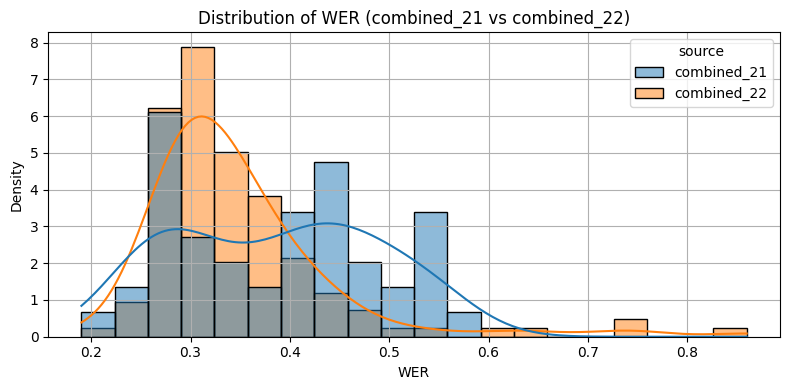

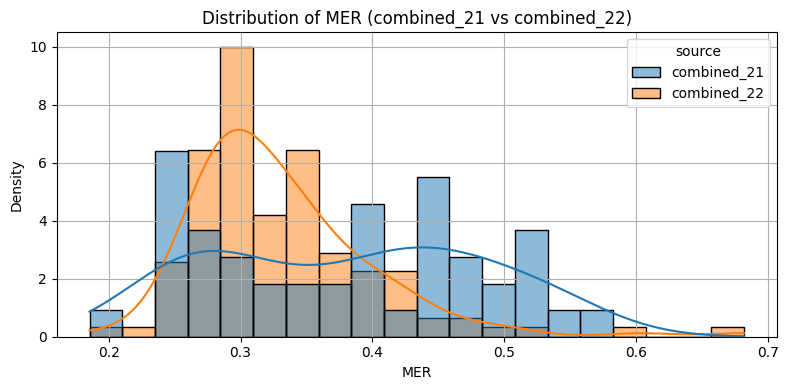

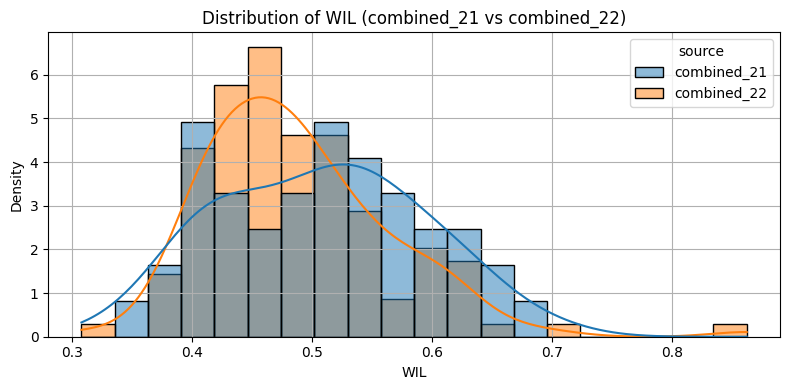

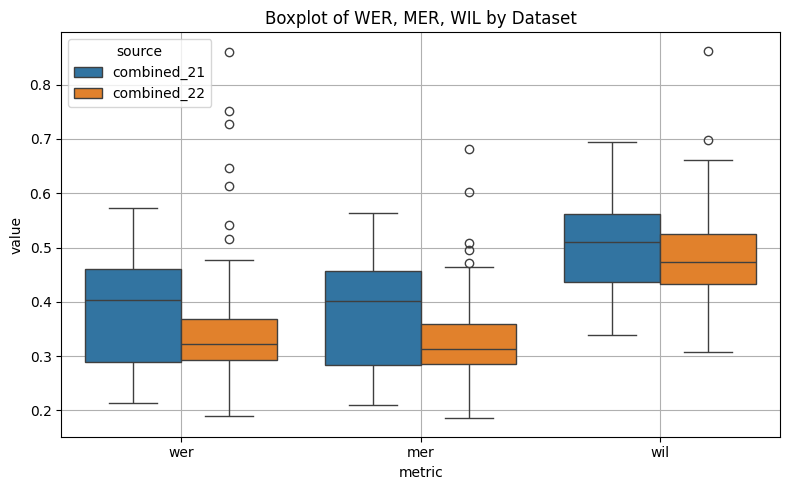

In [39]:

# Labels
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'

df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Descriptive statistics
print("Descriptive statistics:")
print(df_combined.groupby('source')[['wer', 'mer', 'wil']].describe().round(3))

#Histograms
for metric in ['wer', 'mer', 'wil']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_combined, x=metric, hue='source', kde=True, bins=20, stat='density', common_norm=False)
    plt.title(f"Distribution of {metric.upper()} (combined_21 vs combined_22)")
    plt.xlabel(metric.upper())
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Boxplot 
df_melted = df_combined.melt(id_vars=['folder', 'source'], value_vars=['wer', 'mer', 'wil'], 
                             var_name='metric', value_name='value')

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='metric', y='value', hue='source')
plt.title("Boxplot of WER, MER, WIL by Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()


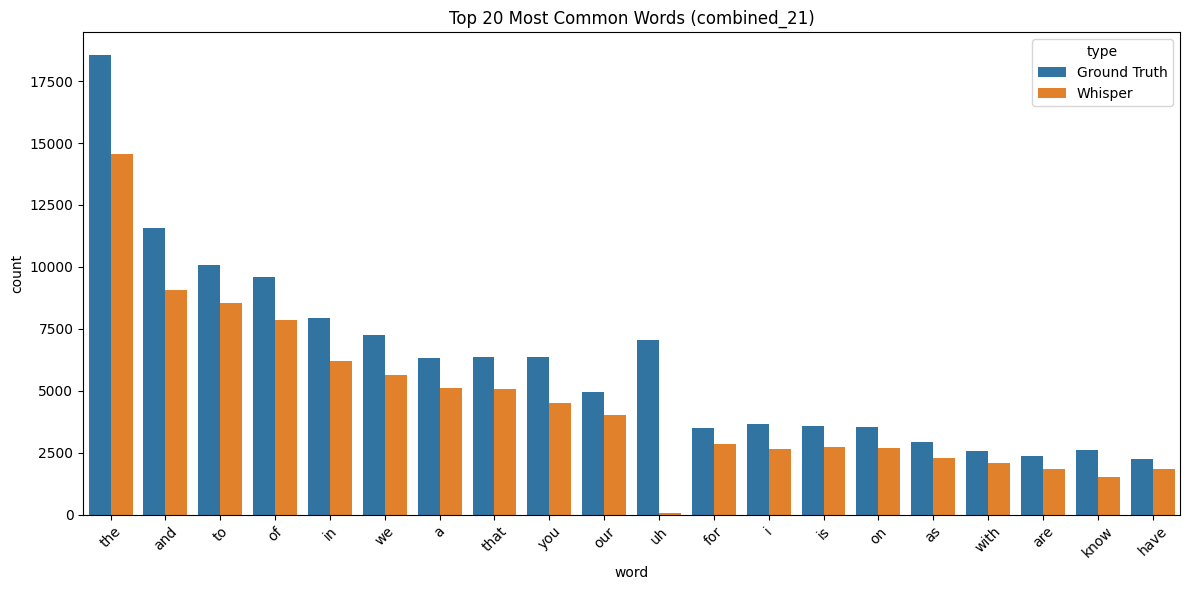

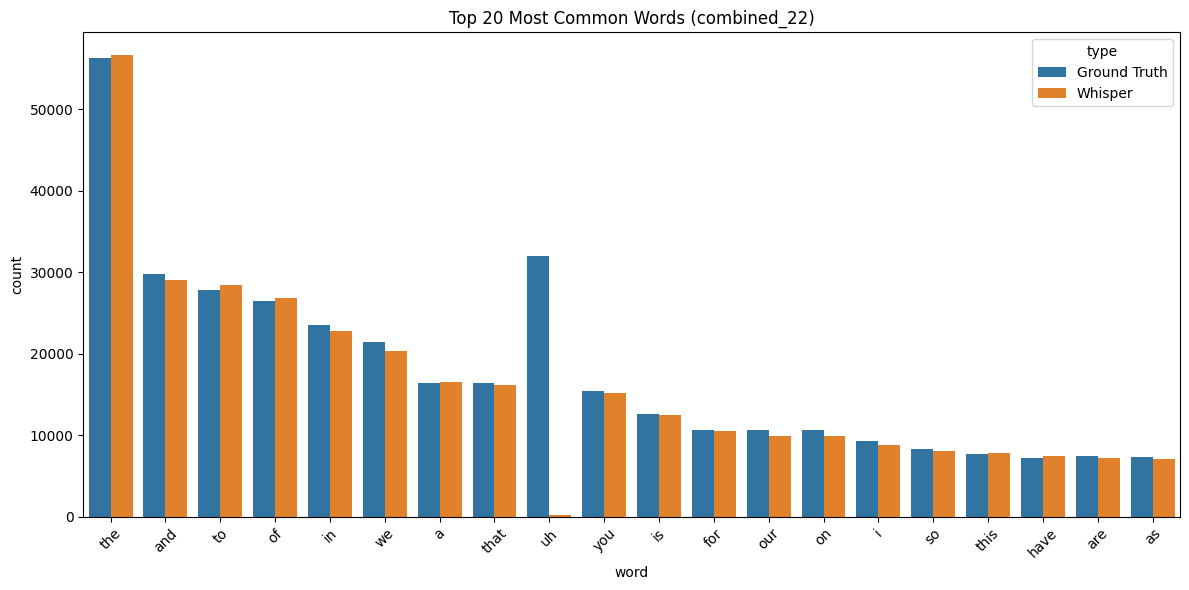

In [17]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def plot_top_words(df_paths, label, top_n=20):
    # Tokenize words
    gt_words = []
    hyp_words = []
    for _, row in df_paths.iterrows():
        gt_words += clean_and_tokenize(row['gt_text'])
        hyp_words += clean_and_tokenize(row['whisper_text'])

    # Count frequencies
    gt_counter = Counter(gt_words)
    hyp_counter = Counter(hyp_words)
    all_words = set(gt_counter) | set(hyp_counter)

    combined_freqs = {word: gt_counter[word] + hyp_counter[word] for word in all_words}
    top_words = sorted(combined_freqs.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_words_list = [word for word, _ in top_words]

    # Create DataFrame for plotting
    data = []
    for word in top_words_list:
        data.append({'word': word, 'count': gt_counter[word], 'type': 'Ground Truth'})
        data.append({'word': word, 'count': hyp_counter[word], 'type': 'Whisper'})
    df_top = pd.DataFrame(data)

    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_top, x='word', y='count', hue='type')
    plt.title(f"Top {top_n} Most Common Words ({label})")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_top_words(df_paths_21, label="combined_21")
plot_top_words(df_paths_22, label="combined_22")


I want to find filler words that are only in the ground truth but not the transcripts


C:\Users\mark.welin\AppData\Local\Temp\ipykernel_3368\1569125944.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x='rel_diff', y='word', palette='Reds_r')


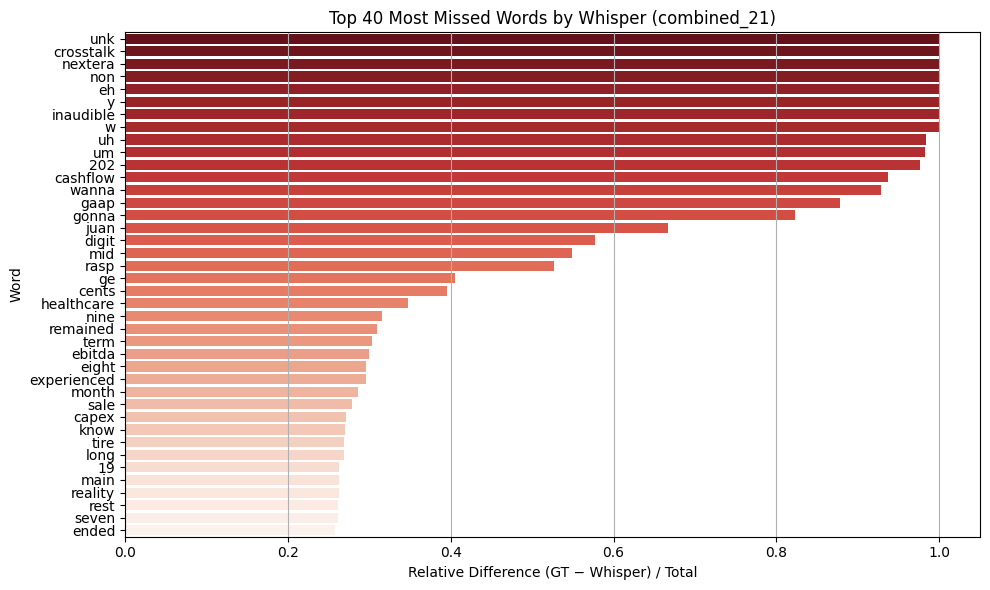

C:\Users\mark.welin\AppData\Local\Temp\ipykernel_3368\1569125944.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x='rel_diff', y='word', palette='Reds_r')


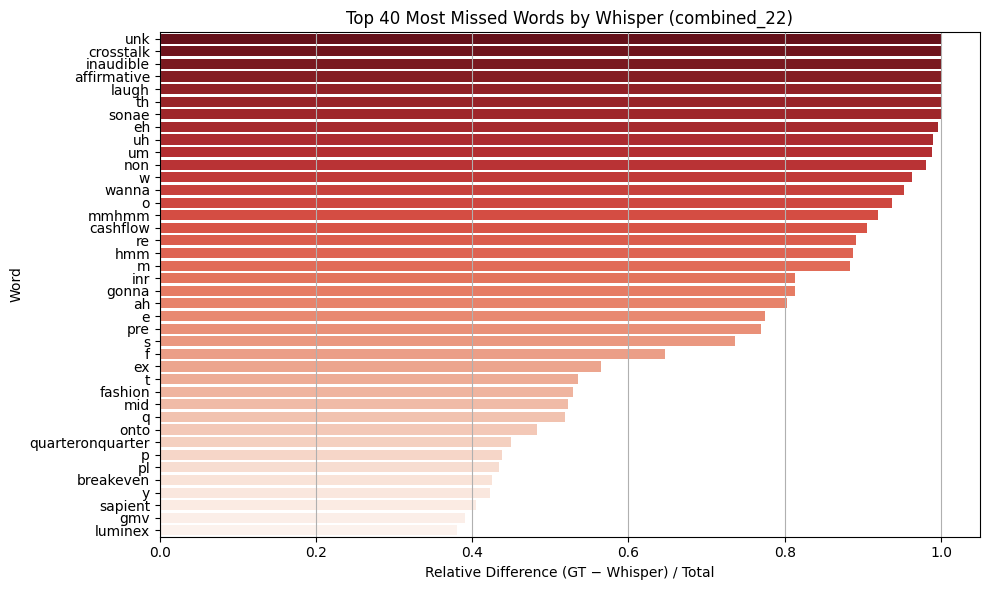

In [7]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def get_top_missed_words(df_paths, label, top_n=40, min_total=50, plot=True):
    gt_words = []
    hyp_words = []
    for _, row in df_paths.iterrows():
        gt_words += clean_and_tokenize(row['gt_text'])
        hyp_words += clean_and_tokenize(row['whisper_text'])

    gt_counter = Counter(gt_words)
    hyp_counter = Counter(hyp_words)
    all_words = set(gt_counter) | set(hyp_counter)

    data = []
    for word in all_words:
        gt_count = gt_counter[word]
        hyp_count = hyp_counter[word]
        total = gt_count + hyp_count
        if total < min_total:
            continue
        rel_diff = (gt_count - hyp_count) / total
        data.append({
            'word': word,
            'gt_count': gt_count,
            'whisper_count': hyp_count,
            'rel_diff': rel_diff
        })

    df_diff = pd.DataFrame(data)
    df_top = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)

    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_top, x='rel_diff', y='word', palette='Reds_r')
        plt.xlabel("Relative Difference (GT − Whisper) / Total")
        plt.ylabel("Word")
        plt.title(f"Top {top_n} Most Missed Words by Whisper ({label})")
        plt.grid(True, axis='x')
        plt.tight_layout()
        plt.show()

    return df_top

# Run for each dataset
df_top_21 = get_top_missed_words(df_paths_21, label='combined_21')
df_top_22 = get_top_missed_words(df_paths_22, label='combined_22')

# Combine top words from both sets
top_words = set(df_top_21['word']) | set(df_top_22['word'])

There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", "th", "mmhmm", "hmm", "ah", "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

-  Altering: Cashflow to Cash flow, Gonna to Going to, Wanna to Want to, Health care to healthcare



Making lists of examples:

In [35]:
# Start context dictionary
context_examples = {word: [] for word in top_words}

chunk_size = 20
window_range = 300 #Window of words you look at on either side of the token
sample_limit = 30  

datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text'].lower()
        whisper_text = row['whisper_text'].lower()

        gt_words = re.findall(r'\b\w+\b', gt_text)
        whisper_words = re.findall(r'\b\w+\b', whisper_text)

        whisper_snippets = [
            ' '.join(whisper_words[i:i+chunk_size])
            for i in range(len(whisper_words) - chunk_size + 1)
        ]

        # Build a lookup for token positions
        word_indices = defaultdict(list)
        for i, token in enumerate(gt_words):
            if token in top_words:
                word_indices[token].append(i)

        for token, indices in word_indices.items():
            # Randomly sample up to 30 positions for this token
            sampled_indices = random.sample(indices, min(sample_limit, len(indices)))

            for i in sampled_indices:
                start = max(i - 10, 0)
                end = min(i + 11, len(gt_words))
                gt_snippet = ' '.join(gt_words[start:end])

                approx_chunk = int(i * len(whisper_snippets) / len(gt_words))
                chunk_start = max(approx_chunk - window_range, 0)
                chunk_end = min(approx_chunk + window_range + 1, len(whisper_snippets))
                local_snippets = whisper_snippets[chunk_start:chunk_end]
                #print(f"Local snippets: {local_snippets}")
                #print(f"GT Snippet: {gt_snippet}")
                best_match, score, _ = process.extractOne(
                    gt_snippet, local_snippets, scorer=fuzz.partial_ratio
                )

                whisper_match = best_match if best_match else '[No match found]'
                whisper_start_index = chunk_start + local_snippets.index(best_match)
                context_examples[token].append({
                    'gt_snippet': gt_snippet,
                    'gt_index': i - 10,  
                    'whisper_snippet': whisper_match,
                    'whisper_index': whisper_start_index,  
                    'score': score,
                    'dataset': label,
                    'folder': row['folder']
                })


In [36]:
rows = []

for word, examples in context_examples.items():
    for ex in examples:
        rows.append({
            "word": word,
            "gt_snippet": ex['gt_snippet'],
            "whisper_snippet": ex['whisper_snippet'],
            "gt_index": ex['gt_index'],
            "whisper_index": ex['whisper_index'],
            "score": ex['score'],
            "folder": ex['folder'],
            "dataset": ex['dataset']
        })

df_matches = pd.DataFrame(rows)
df_matches.to_csv("gt_whisper_matches.csv", index=False)
